In [1]:
import torch 
from torchvision.transforms import Compose
from torch.utils.data import DataLoader,Dataset
from transformers import SwinModel,AutoImageProcessor
from torchvision.transforms import Compose,ToTensor,Normalize,Resize,ToPILImage
import os 
import torchvision
import matplotlib.pyplot as plt

In [2]:
# setting device to GPU
device=torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [3]:
# loading data 
data_transformation=Compose([
    Resize((224,224)),
    ToTensor(),
    ])

training_data_root=r"cat-and-dog/training_set/training_set"
test_data_root=r"cat-and-dog/test_set/test_set"
training_data=torchvision.datasets.ImageFolder(root=training_data_root,transform=data_transformation)
test_data=torchvision.datasets.ImageFolder(root=test_data_root, transform=data_transformation)

  



In [4]:
test_data.class_to_idx

{'cats': 0, 'dogs': 1}

In [5]:
batch_size=64
training_data_loader=DataLoader(dataset=training_data,
                                shuffle=True,
                                batch_size=batch_size,
                                num_workers=4)

test_data_loader=DataLoader(dataset=test_data,
                            shuffle=True,
                            batch_size=batch_size,
                            num_workers=4)



In [6]:
for x,y in training_data_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64


torch.Size([3, 224, 224]) tensor(0)


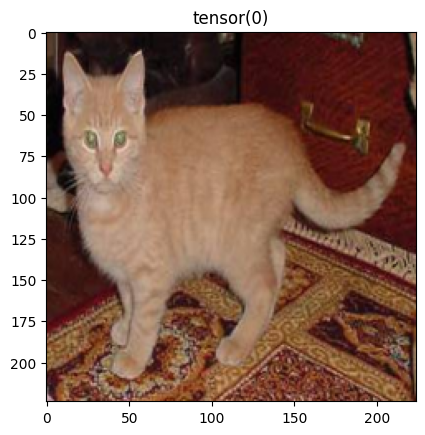

In [7]:
images,labels=next(iter(test_data_loader))
image,label=images[0],labels[0]
print(image.shape,label)
plt.imshow(image.permute(1,-1,0))
plt.title(label)
plt.show()

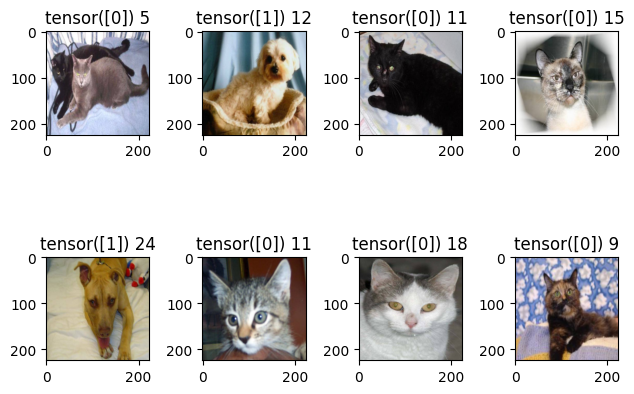

In [11]:

for i, (x,y) in enumerate(test_data_loader):
    plt.subplot(2,4,i+1)
    # Transpose axes and convert to numpy array
    batch_size,channels,height,width=x.shape
    image = x.view(batch_size,channels,height,width)
    
    random_idx=torch.randint(low=0,high=31,size=(1,))
    image=image[random_idx].squeeze(0).permute(1,-1,0)
    # Normalize image to [0, 1]
    plt.imshow(image)
    plt.title(f"{y[random_idx]} {int(random_idx)}")
    if i==7:
        break
plt.tight_layout()
plt.show()

In [12]:
# Modeling 
class classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder=SwinModel.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
        self.avg_pool=torch.nn.AdaptiveAvgPool1d(1)
        self.linear=torch.nn.Linear(49,2)
        
        
    
    def forward(self,x):
        x=x.to(device)
        x=self.encoder(x).last_hidden_state
        x=self.avg_pool(x).squeeze(2)
        x=self.linear(x)
        return x
    
model=classifier().to(device)
        
       

In [13]:
model

classifier(
  (encoder): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
      

In [14]:
# let's print out the number of trainable parameters before freezing the encoder layers
def print_model_params(model):
    trainable_params=[param for param in model.parameters() if param.requires_grad]
    for i, param in enumerate(trainable_params, start=1):
            print(f"Trainable parameter {i}: {param.shape}")
    print(f"number of trainable params {len(trainable_params)}")    
print(print_model_params(model))    

Trainable parameter 1: torch.Size([128, 3, 4, 4])
Trainable parameter 2: torch.Size([128])
Trainable parameter 3: torch.Size([128])
Trainable parameter 4: torch.Size([128])
Trainable parameter 5: torch.Size([128])
Trainable parameter 6: torch.Size([128])
Trainable parameter 7: torch.Size([169, 4])
Trainable parameter 8: torch.Size([128, 128])
Trainable parameter 9: torch.Size([128])
Trainable parameter 10: torch.Size([128, 128])
Trainable parameter 11: torch.Size([128])
Trainable parameter 12: torch.Size([128, 128])
Trainable parameter 13: torch.Size([128])
Trainable parameter 14: torch.Size([128, 128])
Trainable parameter 15: torch.Size([128])
Trainable parameter 16: torch.Size([128])
Trainable parameter 17: torch.Size([128])
Trainable parameter 18: torch.Size([512, 128])
Trainable parameter 19: torch.Size([512])
Trainable parameter 20: torch.Size([128, 512])
Trainable parameter 21: torch.Size([128])
Trainable parameter 22: torch.Size([128])
Trainable parameter 23: torch.Size([128])
T

In [15]:
# freezing the swin encoder params
for param in model.encoder.parameters():
    param.requires_grad=False

In [16]:
# printing out the params after freezing
print_model_params(model)

Trainable parameter 1: torch.Size([2, 49])
Trainable parameter 2: torch.Size([2])
number of trainable params 2


In [17]:
# define the loss and the optimizer
optimizer=torch.optim.Adam(params=model.parameters(),lr=3e-3)
criterion=torch.nn.CrossEntropyLoss()

In [26]:
def train(model,criterion,optimizer,data_loader):
    size=len(data_loader.dataset)
    num_batches=size//batch_size
    model.train()
    training_loss=0
    total=0
    correct=0
    for batch,(x,y) in enumerate(data_loader):
        print(f"batch {batch}/{num_batches}")
        x,y=x.to(device),y.to(device)
        y_pred=model(x)
        loss=criterion(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss+=loss.item()
        _, predicted = torch.max(y_pred, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        if batch % 32== 0:
            print(f"loss {loss.item()}")
    accuracy=correct/size
    print(f"training accuracy at {accuracy}")       
        
        
        
        
    

In [27]:
def test(model,criterion,data_loader):
    correct=0
    total=0
    size=len(data_loader.dataset)
    num_batches=len(data_loader)
    model.eval()
    with torch.no_grad():
      for batch,(x,y) in enumerate(data_loader):
        print(f"batch {batch}/{num_batches}")
        x,y=x.to(device),y.to(device)
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    acc=correct/size
    print(f"Finished testing:  model_accuracy at {acc}/n")
        
        

In [ ]:
epochs=20
model=torch.load("model.pth")
for epoch in range(epochs):
    print(f"epoch {epoch}")
    train(model,criterion,optimizer,training_data_loader)
    test(model,criterion,test_data_loader)

epoch 0
batch 0/125
loss 1.339793086051941
batch 1/125
batch 2/125
batch 3/125
batch 4/125
batch 5/125
batch 6/125
batch 7/125
batch 8/125
batch 9/125
batch 10/125
batch 11/125
batch 12/125
batch 13/125
batch 14/125
batch 15/125
batch 16/125
batch 17/125
batch 18/125
batch 19/125
batch 20/125
batch 21/125
batch 22/125
batch 23/125
batch 24/125
batch 25/125
batch 26/125
batch 27/125
batch 28/125
batch 29/125
batch 30/125
batch 31/125
batch 32/125
loss 1.2800650596618652
batch 33/125
batch 34/125
batch 35/125
batch 36/125
batch 37/125
batch 38/125
batch 39/125
batch 40/125
batch 41/125
batch 42/125
batch 43/125
batch 44/125
batch 45/125
batch 46/125
batch 47/125
batch 48/125
batch 49/125
batch 50/125
batch 51/125
batch 52/125
batch 53/125
batch 54/125
batch 55/125
batch 56/125
batch 57/125
batch 58/125
batch 59/125
batch 60/125
batch 61/125
batch 62/125
batch 63/125
batch 64/125
loss 1.3221946954727173
batch 65/125
batch 66/125
batch 67/125
batch 68/125
batch 69/125
batch 70/125
batch 71

In [21]:
torch.save(model,"model.pth")

In [ ]:
processor=AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
encoder=SwinModel.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
encoder.parameters

In [ ]:
for batch,(x,y) in enumerate(training_data_loader):
    y_pred=model(x)
    print(x.shape)
    print(y.shape)
    print(y_pred.shape)
    break



In [ ]:
with torch.no_grad():   
    
    for batch,(x,y) in enumerate(training_data_loader):
        x=processor(x,return_tensors="pt")
        x=x.pixel_values
        x=encoder(x).last_hidden_state
        x=torch.nn.AdaptiveAvgPool1d(1)(x)
        
        
        
        print(x.shape)
        break